# Jpeg Compression
## Image 5 GMM
### Lauriane Kiersnowski, Anaïs Chibani, Flavie Kolb

In [ ]:
# Importation des librairies
import numpy as np
import holoviews as hv
from PIL import Image
import panel as pn
import cv2
import plotly.express as px
import matplotlib.pyplot as plt
from scipy import fft
from skimage.color import rgb2ycbcr,ycbcr2rgb
from scipy.fft import dctn, idctn

import huffman
from collections import Counter
#import scipy.misc
#from skimage import  color,  morphology
import time

In [ ]:
'''!python -m pip install -U scikit-image
!pip install huffman'''

In [ ]:
# utile pour Codage de Huffman
runBits=1 
bitBits=3
rbBits=runBits+bitBits ##(run,bitSize of coefficient)
#useHuffman=True #modify it if you want
#quantizationRatio=1 #modify it if you want, quantization table=default quantization table * quantizationRatio

# 1. Importation et changement de base colorimétrique

## 1.1. Ouverture de l'image

In [ ]:
%pylab inline
image_name ='fractal.png'
img = cv2.imread(image_name, cv2.IMREAD_COLOR)
px.imshow(img, title ='Image originale de 7181 Ko')

## 1.2 Transfère de couleurs RGB à YCbCr

- Y : luminance (dont l'oeil est très sensible)
- Cb : crominance bleu
- Cr : crominance rouge

In [ ]:
#image originale
originalImg=copy(img)

#transformation en ycbcr
ycbcr=rgb2ycbcr(img)

#transformation en rgb
rgb=(ycbcr2rgb(ycbcr).clip(0,1)*255).astype(uint8)

# affichage Ycbcr
figure()
title('Image YCbCr')
imshow(ycbcr.astype(uint8))


# affichage rgb
figure()
title('Image RGB reconstruite')
imshow(rgb)

# Pour la suite, nous travaillons avec le YCbCr
img=ycbcr

# vérification opération RGB_original > YCbCr > RGB = RGB_original
print( "image_originale to ycbcr to rgb == image_originale ? : ", allclose(rgb,originalImg,atol=1))

## 1.3 Sous échantillonage des chrominances
- Dans cette partie, on parcourt l'image par blocs de 4 pixels pour ne garder que la moyenne de ces 4 pixels pour chacune des 2 chrominances.
- Ainsi on réduit l'information des chrominances.
- Cette opération ne se fait pas sur la luminance car c'est la couche pour laquelle l'oeil humain est la plus sensible.

In [ ]:
def downsampling (chrom):
    #####################
    # input : chrom = canal d'une chrominance (img[:,:,1] ou img[:,:,2])
    # output : chrom_down = canal de la même taille de l'entrée mais avec les valeurs moyennes
    #####################
    h, w = np.shape(chrom)
    chrom_down = np.copy(chrom)
    #chrom_down_bis = np.zeros((int(h/2), int(w/2)))
    for i in range (0,h-2,2):
        for j in range (0,w-2,2):
            chrom_down[i:i+2, j:j+2] = (chrom[i, j] + chrom[i+1,j] + chrom[i,j+1] + chrom[i+1,j+1])/4.
            #chrom_down_bis[int(i/2),int(j/2)] = (chrom[i, j] + chrom[i+1,j] + chrom[i,j+1] + chrom[i+1,j+1])/4.
    return chrom_down

img[:,:,1]=downsampling(img[:,:,1])
img[:,:,2]=downsampling(img[:,:,2]) 

# 2. Transformation de l'image en blocs

Les opérations suivantes (DCT, quantification) se font sur des blocs de tailles 8*8. 

Cette partie consiste à découper l'image en blocs.

In [ ]:
# Travail avec des blocs de taille 8*8 adapté à notre table de quantification
# Ne pas augmenter !
w = 8 
h = w

xLen = img.shape[1]//w 
yLen = img.shape[0]//h 
print("Nombre de découpages en largeur : ", xLen)
print("Nombre de découpages en hauteur : ", yLen)

In [ ]:
# Découpage de l'image en blocs
def toBlocks(img):
    ##############
    # input : img = image de taille (yLen, xLen, 3)
    # output : blocks = 3 tableaux de blocs 8*8 (yLen/8, xLen/8, 8, 8, 3)
    ##############
    #création de 3 matrices : une pour chaque canal
    blocks = zeros((yLen,xLen,h,w,3),dtype=int16)
    for y in range(yLen):
        for x in range(xLen):
            blocks[y][x]=img[y*h:(y+1)*h,x*w:(x+1)*w] #h = 8, w = 8
    return array(blocks)

# Affichage des blocs
def plotBlocks(blocks):
    ###################
    # Affiche les blocks données en entrée
    # input : blocks = tout ou partie de la sortie de toBlocks
    ###################
    xLen=blocks.shape[1]
    yLen=blocks.shape[0]
    for y in range(yLen): #largeur
        for x in range(xLen): #hauteur
            subplot(yLen,xLen,1+xLen*y+x) #subplot(nbre lignes, nbre col, place)
            imshow(blocks[y][x])
            axis('off')

In [ ]:
blocks = toBlocks(img)

In [ ]:
#affichage d'un morceau du découpage blocs
x1 = 210
y1 = 210
figure(figsize=(5,5))
plotBlocks(blocks[y1:y1+20,x1:x1+20])

# 3. DCT (Discrete Cosine Transform) : Transformée en Cosinus Discrete

- Objectif : isoler les fréquences les plus visibles par l'oeil humain.
- On utilise les fonctions dctn et idctn de scipy.fft qui permettent de traiter la DCT sur des tableaux.


En dimension 2 : 

$ DCT(w,h) = \frac{2}{\sqrt{N*N}}C(m)C(n)\sum_{i=0}^{N-1}\sum_{j=0}^{N-1}pixel(i,j)\cos{\frac{(2i+1)w\pi}{2N}} \cos{\frac{(2j+1)h\pi}{2N}}$
  
Avec $C(k)=\frac{1}{\sqrt{2}}$ quand $k=0 $ et $C(k)= 1 $ sinon.
    
Avec N la largeur/la hauteur du bloc : 8*8. 



- L'opération DCT/iDCT n'entraine que peu de pertes (liées aux arrondis machine)

In [ ]:
# Définition de la DCT sur un bloc de taille 8*8 sur un seul canal
N = 8 # = h = w

# Décomposition en cosinus
def DCT_b(bl, N):
    #############
    # inputs : bl = un bloc de taille N*N (un seul canal)
    #         N = taille du bloc (8)
    # output : DCT_blocs = résultat de la DCT, taille N*N
    #############
    
    DCT_blocs = np.zeros((N, N)) # 
    DCT_blocs[0:N ,0:N] = dctn(bl[0:N , 0:N], type = 2,  norm = 'ortho')
    return DCT_blocs

# Décomposition inverse
def iDCT_b(bl, N):
    #############
    # input : bl = un bloc de taille N*N (un seul canal)
    #         N = taille du bloc (8)
    # output : iDCT_blocs = résultat de la DCT inverse, taille N*N
    #############
    iDCT_blocs = np.zeros((N, N)) # 
    iDCT_blocs[0:N ,0:N] = idctn(bl[0:N , 0:N], type = 2,  norm = 'ortho')
    return iDCT_blocs

In [ ]:
# Exmemple de la DCT/iDCT sur un bloc 8*8
figure(figsize=(9.5,9.5))

# Exemple de DCT sur un bloc de l'image    
subplot(3,3,1)
title('Original canal Y')
imshow(blocks[0][0][:,:,0], cmap = cm.gray)
subplot(3,3,2)
title('Original canal Cb')
imshow(blocks[0][0][:,:,1], cmap = cm.gray)
subplot(3,3,3)
title('Original canal Cr')
imshow(blocks[0][0][:,:,2], cmap = cm.gray)
    
subplot(3,3,4)
title('DCT canal Y')
imshow(DCT_b(blocks[0][0][:,:,0], 8), cmap = cm.gray)
subplot(3,3,5)
title('DCT canal Cb')
imshow(DCT_b(blocks[0][0][:,:,1], 8), cmap = cm.gray)
subplot(3,3,6)
title('DCT canal Cr')
imshow(DCT_b(blocks[0][0][:,:,2], 8), cmap = cm.gray)

subplot(3,3,7)
title('iDCT canal Y')
imshow(iDCT_b(DCT_b(blocks[0][0][:,:,0], 8), 8), cmap = cm.gray)
subplot(3,3,8)
title('iDCT canal Cb')
imshow(iDCT_b(DCT_b(blocks[0][0][:,:,1], 8), 8), cmap = cm.gray)
subplot(3,3,9)
title('iDCT canal Cr')
imshow(iDCT_b(DCT_b(blocks[0][0][:,:,2], 8), 8), cmap = cm.gray)

## 3.1 DCT sur l'image entière, i.e. sur tous les blocs

In [ ]:
# DCT sur tous les blocs de l'image et sur les 3 canaux
def DCT_AllBlocs(blocks): 
    #####################
    # Calcul de la DCT sur tous les blocs de l'image et sur les 3 canaux
    # input : blocks = le découpage en blocs de l'image (yLen/8, xLen/8, 8, 8, 3)
    # output : dctBlocks (yLen/8, xLen/8, 8, 8, 3)
    #####################
    
    #création de trois tableaux (un pour chaque cannal)
    #contenant des blocs de taille 8*8 
    dctBlocks = zeros((yLen,xLen,h,w,3)) 
    
    for y in range(yLen): #largeur
        for x in range(xLen): #hauteur
            d = zeros((h,w,3))
            for i in range(3): # parcours des canaux
                block=blocks[y][x][:,:,i] # un bloc un canal
                d[:,:,i] = DCT_b(block, 8)
            dctBlocks[y][x]=d
    return dctBlocks

In [ ]:
# on définit la dct inverse
def iDCT_AllBlocs(blocks):    
    #####################
    # Calcul de la DCT inverse sur tous les blocs de l'image et sur les 3 canaux
    # input : blocks = le découpage en blocs de l'image (yLen/8, xLen/8, 8, 8, 3)
    # output : idctBlocks (yLen/8, xLen/8, 8, 8, 3)
    #####################
    idctBlocks = zeros((yLen,xLen,h,w,3)) 
    for y in range(yLen):
        for x in range(xLen):
            d = zeros((h,w,3))
            for i in range(3):
                block=blocks[y][x][:,:,i] # un bloc un canal
                d[:,:,i] = iDCT_b(block, 8)
            idctBlocks[y][x]=d
    return idctBlocks

In [ ]:
blocks = toBlocks(img)
# dctBlocks est l'ensemble des blocs de l'image ayant subit la dct
dctBlocks = DCT_AllBlocs(blocks)

## 3.2 Transfomation DCT en image : 

- Affichage de l'image après l'opération de DCT


In [ ]:
def blocks2img(blocks):
    ###################
    # Fonction permettant de passer du format bloc au format image
    # input : blocks = image au format blocs (yLen/8, xLen/8, 8, 8, 3) 
    # output : img = image en format 'classique' (yLen, xLen, 3)
    # 
    ###################
    img = zeros((yLen*h,xLen*w,3))
    # opération inverse à la création des blocs
    for y in range(yLen):
        for x in range(xLen):
            img[y*h:y*h+h,x*w:x*w+w]=blocks[y][x] # chaque bloc prend la place de 8*8 pixels
    return img
newImg= blocks2img(dctBlocks)

In [ ]:
px.imshow(newImg.clip(0,1)*255, title = "DCT sur toute l'image")

In [ ]:
# channel luminance
px.imshow(newImg[:,:,0].clip(0,1)*255, color_continuous_scale = 'gray', title = "DCT sur la luminance")

In [ ]:
px.imshow(newImg[:,:,1].clip(0,1)*255, color_continuous_scale = 'gray', title = "DCT sur Cb")

In [ ]:
px.imshow(newImg[:,:,2].clip(0,1)*255, color_continuous_scale = 'gray', title = "DCT sur Cr")

# 4. Quantification

## 4.1 Matrice Q 'classique'

- Le choix de la matrice Q est très important pour éviter les artefacts.
- Certaines sources proposent des matrices Q différentes pour les luminance et les chrominances.
- Ici nous choisissons la matrice Q 'classique' (récupérée sur internet).

In [ ]:
# La quantification permet de diminuer les hautes fréquences mises en évidence avec la DCT
Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61], # Matrice de quantification
       [12, 12, 14, 19, 26, 58, 60, 55],
       [14, 13, 16, 24, 40, 57, 69, 56], 
       [14, 17, 22, 29, 51, 87, 80, 62], 
       [18, 22, 37, 56, 68, 109, 103, 77], 
       [24, 35, 55, 64, 81, 104, 113, 92], 
       [49, 64, 78, 87, 103, 121, 120, 101], 
       [72, 92, 95, 98, 112, 100, 103, 99]])

In [ ]:
# En sommant 3 fois le tableau on obtient un objet de taille (3,8,8)
# move axis 0,2 passe la dimension 0 en dimension 2
# la matrice de quantification Q3 est en taille (8,8,3)
Q3 =  moveaxis(array([Q]+[Q]+[Q]),0,2) 

# Création d'une matrice Q_artefact pour mettre en évidence l'importance d'un bon choix de Q.
Q_artefact = 5*Q3

#faire une copy == très important !
qDctBlocks=copy(dctBlocks)
qDctBlocks=(qDctBlocks/Q3).round().astype('int16') #Division par la matrice de quantification
print(qDctBlocks.shape) # la taille reste la même

#DCT avec une 'mauvaise' matrice de quantification pour voir les artefacts
qDctBlocks_artefact=copy(dctBlocks)
qDctBlocks_artefact=(qDctBlocks_artefact/Q_artefact).round().astype('int16') #Division par la matrice de quantification
print(qDctBlocks_artefact.shape) # la taille reste la même

In [ ]:
def exemple(block):
    subplot(1,3,1)#Y
    imshow(block[76][200][:,:,0],cmap=cm.gray)
    subplot(1,3,2)#Cb
    imshow(block[76][200][:,:,1],cmap=cm.gray)
    subplot(1,3,3)#Cr
    imshow(block[76][200][:,:,2],cmap=cm.gray)

exemple(dctBlocks)
title("DCT blocs origninaaux")
figure()
exemple(qDctBlocks)
title("DCT blocs quantifiées")
figure()
exemple(qDctBlocks_artefact)
title("DCT blocs avec 'mauvaise' quantification")

## 4.2 Dct quantifiée en image : 

In [ ]:
qDctImg=blocks2img(qDctBlocks)
# on voit moins de hautes fréquences ! > super

In [ ]:
px.imshow(qDctImg.clip(0,1)*255)

De nombreuses hautes fréquences ont disparu, laissant principalement les informations en haut à gauche.
L'étape de quantification a bien fonctionné.

## 4.4 Décompression (reconstruction d'image) de la DCT et des DCT quantifiées


In [ ]:
plt.figure(figsize=(15, 15))

plt.subplot(1,3,1)
plt.title("Wrong quantized DCT")
dedctBlocks_wrong=iDCT_AllBlocs(qDctBlocks_artefact*Q_artefact)
plt.imshow((ycbcr2rgb(blocks2img(dedctBlocks_wrong)).clip(0,1)*255).astype(uint8)[600:750,600:750])

plt.subplot(1,3,2)
plt.title("Quantized DCT")
dedctBlocks=iDCT_AllBlocs(qDctBlocks*Q3)
plt.imshow((ycbcr2rgb(blocks2img(dedctBlocks)).clip(0,1)*255).astype(uint8)[600:750,600:750])

plt.subplot(1,3,3)
plt.title("Original DCT")
dedctBlocks=iDCT_AllBlocs(dctBlocks)
plt.imshow((ycbcr2rgb(blocks2img(dedctBlocks)).clip(0,1)*255).astype(uint8)[600:750,600:750])

figure()

L'image est bien reconstruite. On remarque bien les artefacts dans la cas de l'utilisation d'une mauvaise matrice de quantification.

# 5. Stockage : Zigzag et codage de Huffman

- L'objectif est de stocker l'image le plus légèrement possible.

## 5.1 Zig-Zag
Pour un bloc, on parcourt la matrice en ZigZag c'est à dire ses diagonales une à une en démarrant du coin haut gauche. On créé une liste des coefficients du bloc: ainsi les hautes valeurs se retrouve au début de la liste.

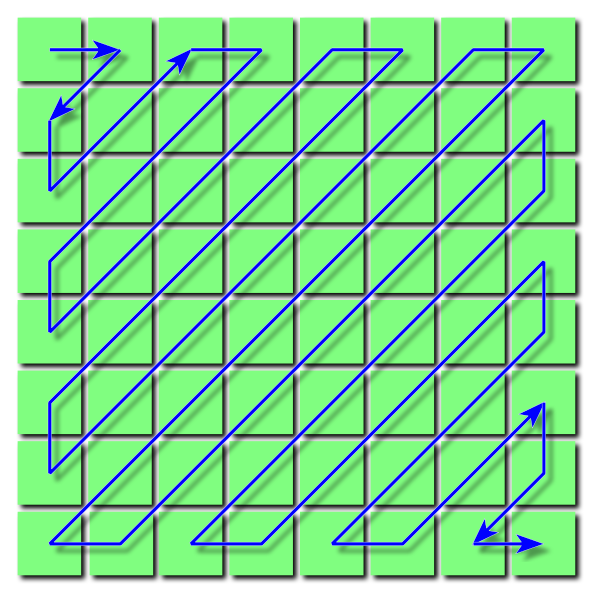

In [ ]:
def zigZag(block):
    lines=[[] for i in range(h+w-1)] 
    for y in range(h): 
        for x in range(w): 
            i=y+x 
            if(i%2 ==0):  #diagonale que l'on remonte
                lines[i].insert(0,block[y][x])  #diagonale que l'on descend
            else:  
                lines[i].append(block[y][x]) 
    return array([coefficient for line in lines for coefficient in line])


In [ ]:
print('exemple de codage Zigzag sur le bloc : \n', qDctBlocks[0][0][:,:,0])
print('Codage ZigZag : ', zigZag(qDctBlocks[0][0][:,:,0]))

In [ ]:
print('exemple de codage Zigzag sur le bloc : \n', qDctBlocks[0][0][:,:,1])
print('Codage ZigZag : ', zigZag(qDctBlocks[0][0][:,:,1]))
print('exemple de codage Zigzag sur le bloc : \n', qDctBlocks[0][0][:,:,2])
print('Codage ZigZag : ', zigZag(qDctBlocks[0][0][:,:,2]))

## 5.2 Codage de Huffman

In [ ]:
def huffmanCounter(zigZagArr):
    ##########################
    # Compte la fréquence de chaque nombre
    # input : zigZagArr = codage zigZag d'un channel
    ##########################    
    rbCount=[]
    run=0
    for AC in zigZagArr[1:]:
        if(AC!=0):
            AC=max(AC,1-2**(2**bitBits-1)) if AC<0 else min(AC,2**(2**bitBits-1)-1)
        if(run>2**runBits-1):
            runGap=2**runBits
            k=run//runGap
            for i in range(k):
                rbCount.append('1'*runBits+'0'*bitBits)
            run-=k*runGap
        run=min(run,2**runBits-1) 
        bitSize=min(int(ceil(log(abs(AC)+0.000000001)/log(2))),2**bitBits-1)
        rbCount.append(format(run<<bitBits|bitSize,'0'+str(rbBits)+'b'))
        run=0
    else:
        run+=1
    rbCount.append("0"*(rbBits))
    return Counter(rbCount)

In [ ]:
rbCount=zeros(3,dtype=Counter)
rbCount[0]=huffmanCounter(zigZag(qDctBlocks[0][0][:,:,0]))
print('compteur luminance : ', rbCount[0])
rbCount[1]=huffmanCounter(zigZag(qDctBlocks[0][0][:,:,1]))
print('compteur chrominance 1 : ', rbCount[1])
rbCount[2]=huffmanCounter(zigZag(qDctBlocks[0][0][:,:,2]))
print('compteur chrominance 2 : ', rbCount[2], '\n')

rbCount=sum(rbCount)

print("Compteur pour les 3 channelr :\n"+str(rbCount))

print("\nHuffman Coding:\n"+str(huffman.codebook(rbCount.items())))

Le codage d'Huffman nous donne bien des codages binaires. La longueur du codage en bit diminue proportionnellement au nombre de fois d'apparition de la valeur dans la matrice zigzag.

#### Calcul de l'entropie du codage de huffman

 L'entropie du codage de Huffman représente le nombre moyen de bits pour coder un pixel. Elle peut être calculée en utilisant la formule suivante :

$$H = \sum(pi * li)$$

Avec : 
    
- H : entropie du code de Huffman
- pi : probabilité d'un symbole ('1', '01, '11', '10', '00', '010',...)
- li : longueur du code de Huffman associé à ce symbole. (1, 2, 2, 2, 2, 3, ...)

    

In [ ]:
def entropie(proba, taille):
    ########################
    # input : proba : liste des fréquences d'apparitions des nombre
    #         taille : liste du nombre de bit nécéssaire pour coder les nombre
    #                !! les indices deux listes doivent correspondre !!
    ########################
    S = 0
    for i in range(len(proba)):
        S += proba[i]*taille[i]
    return S

In [ ]:
p = rbCount
proba = []
resp = {key: val for key, val in sorted(p.items(), key = lambda ele: ele[0])}

proba = list(resp.values()) #liste ordonnées selon le nb de bit des fréquences d'apparition
proba = proba/sum(proba)   

huff2 = (huffman.codebook(rbCount.items()))
res = {key: val for key, val in sorted(huff2.items(), key = lambda ele: ele[0])}
codes = list(res.values())
taille = []
for i in range(len(codes)):
    taille.append(len(codes[i]))
    
print("Entropie du codage de Huffman", entropie(proba, taille)) #taille minimale de l'encodage

Les codes ci-dessous codent l'image entière, au lieu de seulement une partie comme précédemment.

In [ ]:
def huffmanCounterWholeImg(blocks):
    rbCount=zeros(xLen*yLen*3,dtype=Counter)
    zz=zeros(xLen*yLen*3,dtype=object)
    #parcours blocks
    for y in range(yLen):
        for x in range(xLen):
            for i in range(3):
                zz[y*xLen*3+x*3+i]=zigZag(blocks[y, x,:,:,i])
                rbCount[y*xLen*3+x*3+i]=huffmanCounter(zz[y*xLen*3+x*3+i])
    return sum(rbCount),zz
rbCount,zz=huffmanCounterWholeImg(qDctBlocks)
hfm=huffman.codebook(rbCount.items())
sortedHfm=[[hfm[i[0]],i[0],rbCount[i[0]]] for i in rbCount.most_common()]
sortedHfm

In [ ]:
print("(run,bit) occupies: "+str(sum(array(rbCount.most_common(),dtype=int32)[:,1]*rbBits)/8/2**10)+" KB")
print("(run,bit) after Huffman Coding occupies: "+str(sum([rbCount[k]*len(v) for k,v in hfm.items()])/8/2**10)+" KB")

In [ ]:
p_entier = rbCount
proba_entier = []
resp_entier = {key: val for key, val in sorted(p_entier.items(), key = lambda ele: ele[0])}

proba_entier = list(resp_entier.values()) #liste ordonnées selon le nb de bit des fréquences d'apparition
proba_entier = proba_entier/sum(proba_entier)   
huff3 = (huffman.codebook(rbCount.items()))
res_entier = {key: val for key, val in sorted(huff3.items(), key = lambda ele: ele[0])}
codes_entier = list(res_entier.values())
taille_entier = []
for i in range(len(codes_entier)):
    taille_entier.append(len(codes_entier[i]))
    
print("Entropie du codage de Huffman pour l'image entière", entropie(proba_entier, taille_entier)) #taille minimale de l'encodage